In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/features-of-lol/features_train_low.pkl
/kaggle/input/features-of-lol/features_eval15_low.pkl
/kaggle/input/features-of-lol/features_eval15_high.pkl
/kaggle/input/features-of-lol/features_train_high.pkl
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k

# Import Modules

In [4]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now
import pickle
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [5]:
# load features from pickle
with open("/kaggle/input/features-of-lol/features_train_high.pkl", 'rb') as f:
    features = pickle.load(f)

In [6]:
with open("/kaggle/input/features-of-lol/features_eval15_high.pkl", 'rb') as f:
    features_test = pickle.load(f)

#  Load the Captions Data
 
Let us store the captions data from the text file

In [7]:
with open("/kaggle/input/blip-captions/blip_captions_train.csv", 'r') as f:
    captions_doc = f.read()

In [8]:
with open("/kaggle/input/blip-captions/blip_captions_test.csv", 'r') as f:
    captions_doc_test = f.read()

Now we split and append the captions data with the image

In [9]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/485 [00:00<?, ?it/s]

In [10]:
mapping_test = {}
# process lines
for line in tqdm(captions_doc_test.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping_test[image_id] = []
    # store the caption
    mapping_test[image_id].append(caption)

  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
len(mapping),len(mapping_test)

(485, 15)

# Preprocess Text Data

In [12]:
def clean(mapping):
    i=1
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption


In [13]:
# preprocess the text
clean(mapping),clean(mapping_test)

(None, None)

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
for key in mapping_test:
    for caption in mapping_test[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

500

In [16]:
all_captions[:20]

['startseq white vanity with mirror and stool endseq',
 'startseq bed with stuffed animal on it endseq',
 'startseq blue floor in building with large window endseq',
 'startseq teddy bear is sitting on bed endseq',
 'startseq shower with shower head and shower curtain endseq',
 'startseq large building under construction endseq',
 'startseq table with bunch of bowling balls on it endseq',
 'startseq box of tea endseq',
 'startseq vase with flowers in it endseq',
 'startseq teddy bear sitting next to bottle of water endseq',
 'startseq bed with stuffed animal on it endseq',
 'startseq stuffed bear sitting next to vase and vase endseq',
 'startseq pool with swimming board and ladder endseq',
 'startseq bunch of fruit and stuffed bear endseq',
 'startseq blue fire hydrant sitting in courtyard endseq',
 'startseq wooden closet with lot of clothes hanging on it endseq',
 'startseq bunch of flowers and stuffed animals on desk endseq',
 'startseq silver bowl endseq',
 'startseq teddy bear sit

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

305

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

22

# Train Test Split

In [20]:
train = list(mapping.keys())
test = list(mapping_test.keys())

Now we will define a batch and include the padding sequence

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

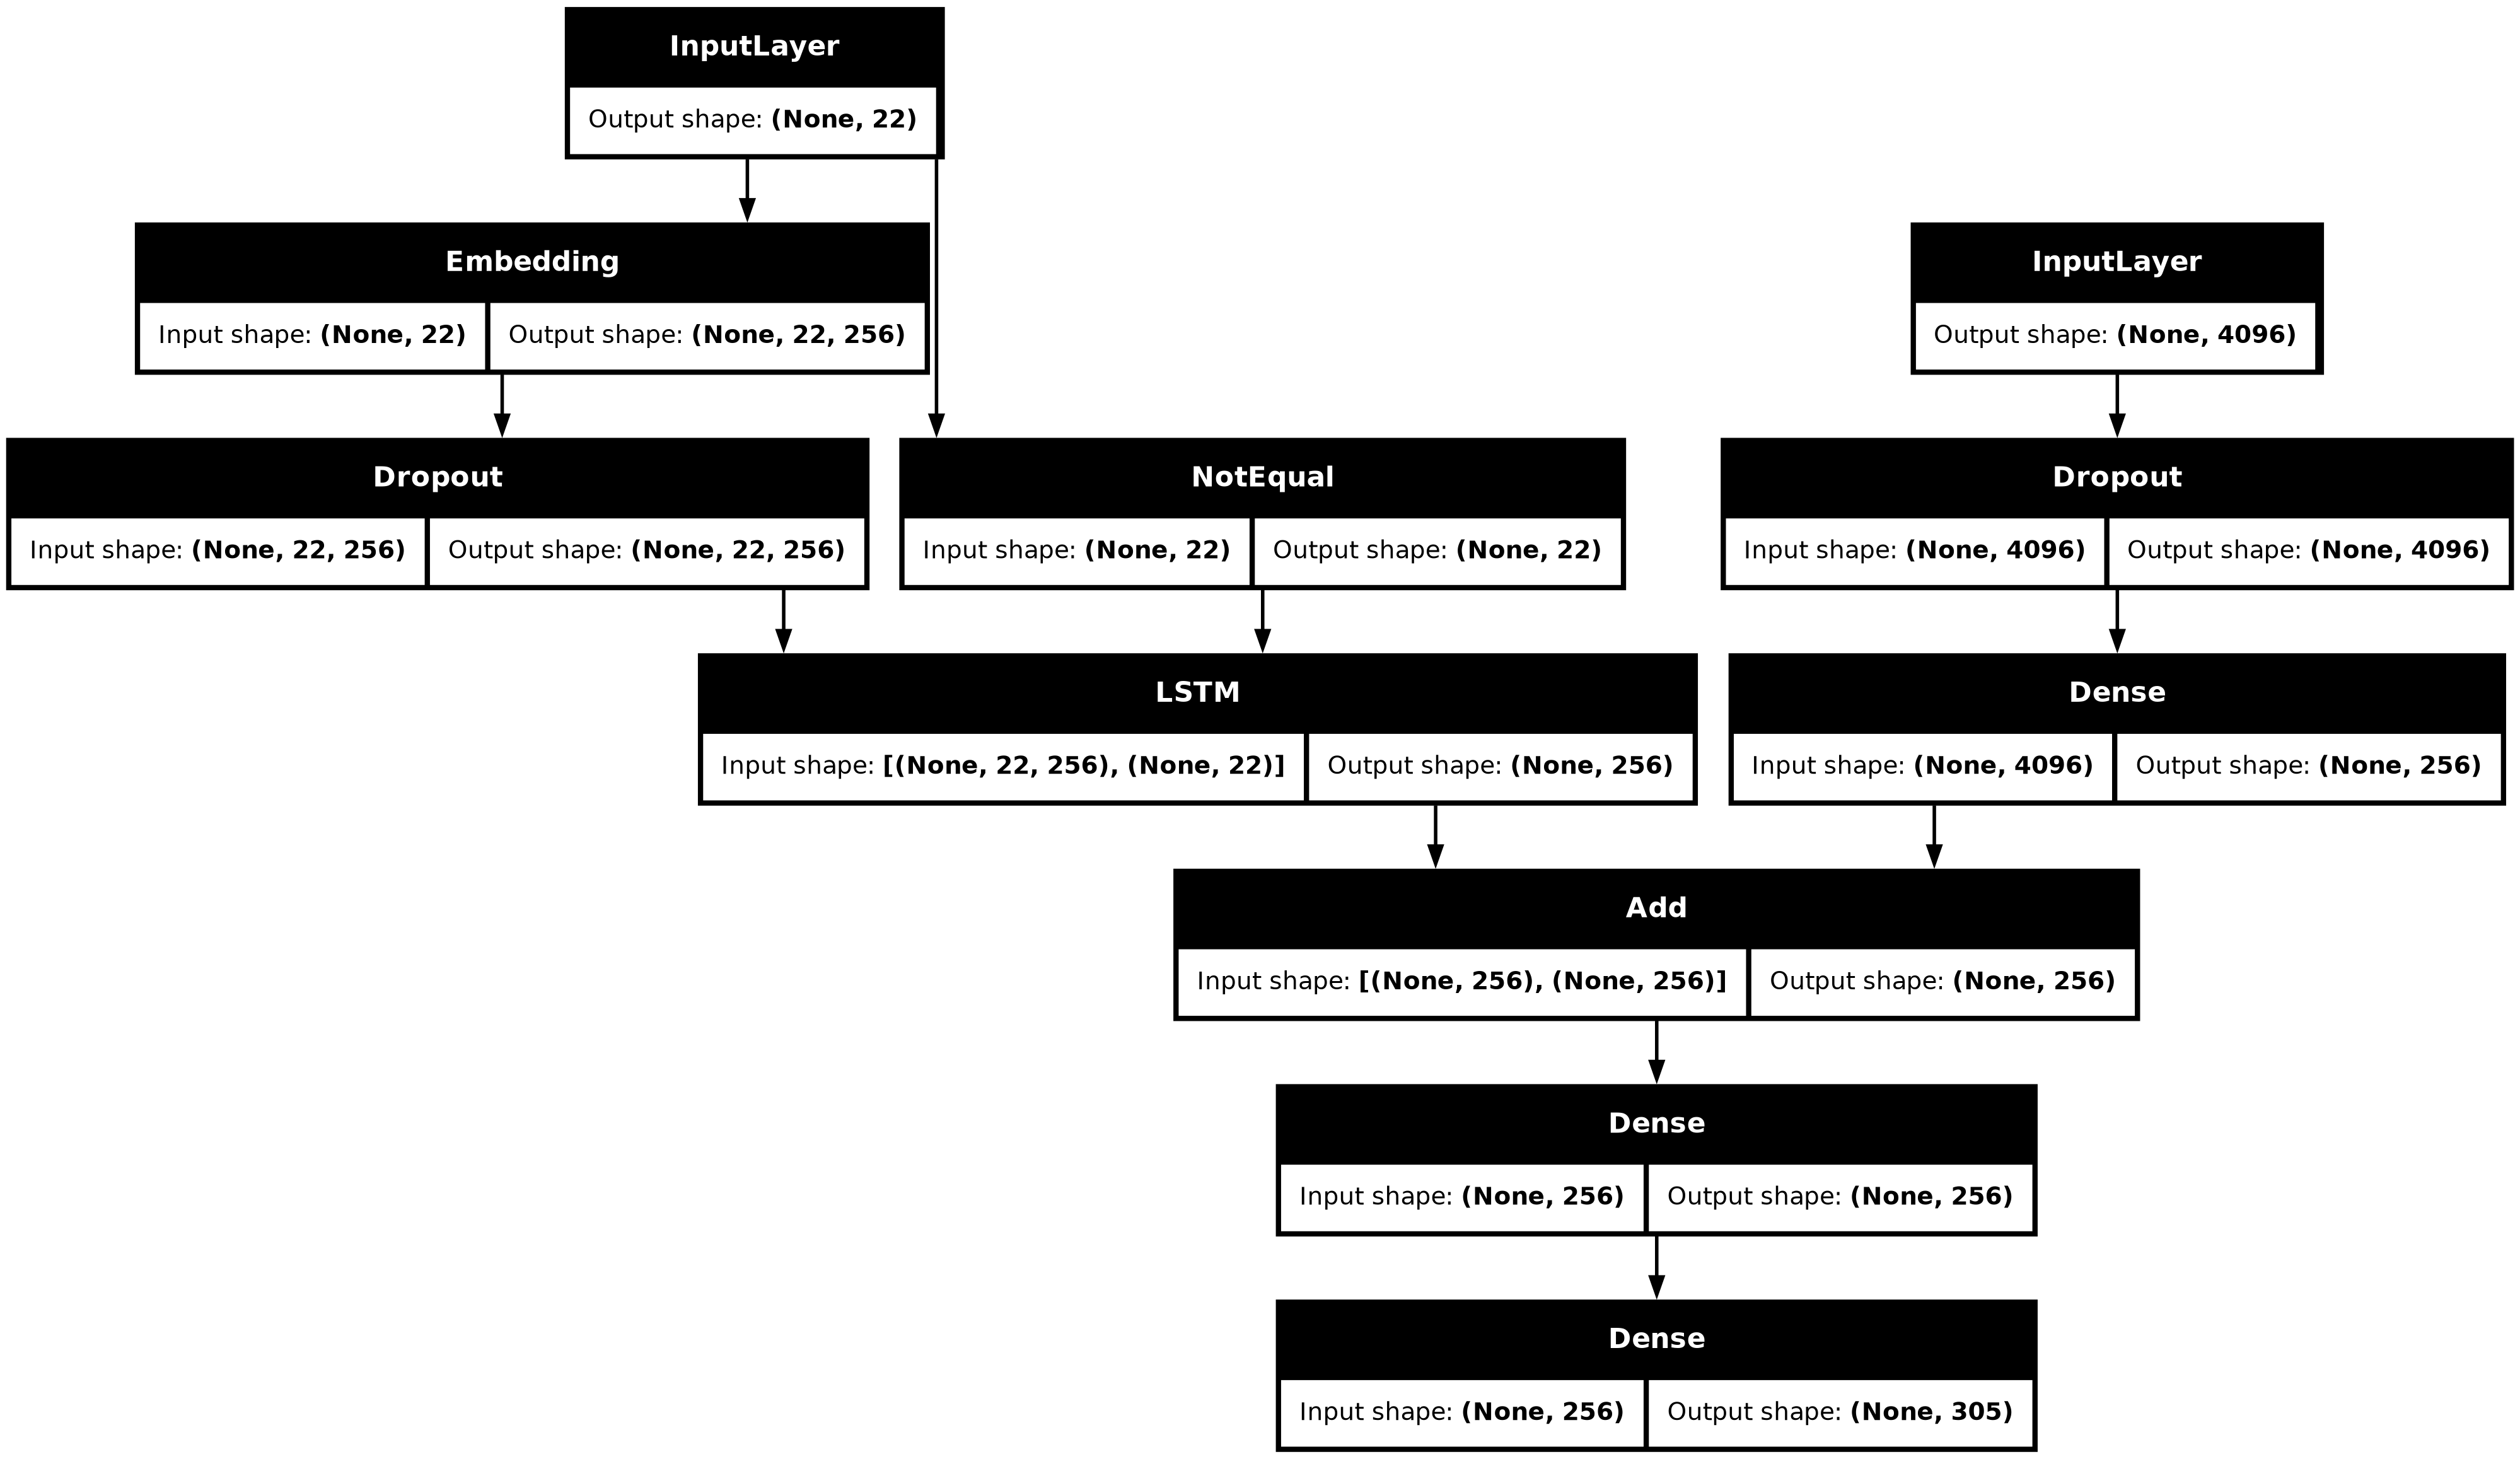

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model_1 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model_1.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model_1, show_shapes=True)

# Train Model

Now let us train the model

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model_1.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


In [23]:
# save the model
model_1.save('/kaggle/working/best_model.h5')

# Generate Captions for the Image

In [24]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

Convert the predicted index from the model into a word

In [25]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model_1.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

Caption generator appending all the words for an image


The caption starts with 'startseq' and the model continues to predict the caption until the 'endseq' appeared

# Model Validation

In [26]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping_test[key]
    # predict the caption for image
    y_pred = predict_caption(model_1, features_test[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/15 [00:00<?, ?it/s]

BLEU-1: 0.046377
BLEU-2: 0.215353


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1012212859_01547e3f17.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("/kaggle/input/lol-dataset/lol_dataset/eval15/high", image_name)
    image = Image.open(img_path)
    captions = mapping_test[image_id]
    print('---------------------Caption---------------------')
    for caption in captions:
        print(caption)
    
    plt.imshow(image)

---------------------Caption---------------------
startseq bookcase with cat on it endseq


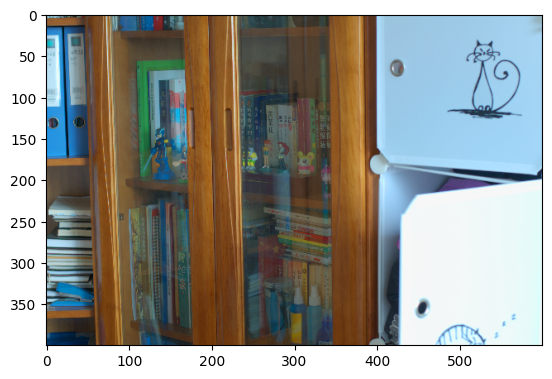

In [29]:
generate_caption("1.png")